# ELECTROMYOGRAPHY BASED CLASSIFICATION OF WALKING AND SITTING

### Feature Extraction Functions

In [19]:


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal.transpose()))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    
    umbral = signal >= th
    return np.sum(umbral) / len(signal)

def zcruce(X, th):
    X=X.transpose()
    cruce = 0
    for cont in range(len(X) - 1-1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce

### Time Features Estimation

In [20]:
def time_features_estimation(signal):#, frame, step):
    variance = []
    rms = []
    iemg = []
    mav = []
    log_detector = []
    wl = []
    aac = []
    dasdv = []
    zc = []
    wamp = []
    myop = []

    th = np.mean(signal) + .3 * np.std(signal)
    x = signal  #[i - frame:i]
    variance.append(np.var(x))
    rms.append(np.sqrt(np.mean(x ** 2)))
    iemg.append(np.sum(abs(x)))  # Integral
    mav.append(np.sum(np.absolute(x)) / len(x))  # Mean Absolute Value
    wl.append(np.sum(abs(np.diff(x.transpose()))))  # Wavelength
    aac.append(np.sum(abs(np.diff(x.transpose()))) / len(x))  # Average Amplitude Change
    dasdv.append(math.sqrt((1 / (len(x) - 1)) * np.sum((np.diff(x)) ** 2)))  # Difference absolute standard deviation value
    zc.append(zcruce(x.transpose(), th))  # Zero-Crossing
    wamp.append(wilson_amplitude(x, th))  # Willison amplitude
    myop.append(myopulse(x, th))  # Myopulse percentage rate
    time_features_matrix = np.column_stack((variance, rms, iemg, mav, wl, aac, dasdv, zc, wamp, myop))
    time_headers  = ('variance', 'rms', 'iemg', 'mav', 'wl', 'aac', 'dasdv', 'zc', 'wamp', 'myop')                                                  
    return time_features_matrix,  time_headers


In [21]:

def time_fea(data_in):
    
    data = pd.DataFrame(data_in)
    time_matrix=[]
    time_matrix_df = []
    var_val = []
    HEA1=[]
    TFE1=[]
    no_of_ch = data.shape[1]
    
    for col in range(0,no_of_ch , 1):
        data_in = data.iloc[:,col]
        signal= pd.DataFrame(data_in.values) 
        signal = signal.to_numpy()
        S,H = time_features_estimation(signal)
        TFE = np.array(S)
        HEA = np.array(H)
        if col == 0 :
            TFE1 = TFE
            HEA1 = HEA
            
        else :
            TFE1 = np.hstack([TFE1,TFE])
            HEA1 =np.hstack([HEA1,HEA])
 
    return   TFE1,HEA1
    

### Frequency Features Functions 

In [22]:
def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)
    return fh, power

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def frequency_ratio(frequency, power):
    power_low = power[(frequency >= 10) & (frequency <= 250)]
    power_high = power[(frequency > 250) & (frequency <= 500)]
    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    return ULC / UHC

def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


### Frequency Features Estimation

In [23]:
def frequency_features_estimation(matrix, fs):
    
    fr = []
    mnp = []
    tot = []
    mnf = []
    mdf = []
    pkf = []

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        frequency, power = spectrum(x, fs)

        fr.append(frequency_ratio(frequency, power))  # Frequency ratio
        mnp.append(np.sum(power) / len(power))  # Mean power
        tot.append(np.sum(power))  # Total power
        mnf.append(mean_freq(frequency, power))  # Mean frequency
        frequency_features_matrix = np.row_stack((fr, mnp, tot, mnf))#, mdf, pkf))
        names = ['FR_' + str(i) for i in range(matrix.shape[1])]
        names.extend(['MNP_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['TOT_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['MNF_' + str(i) for i in range(matrix.shape[1])])
    freq_fea=np.array(frequency_features_matrix)
    freq_fea = freq_fea.reshape(-1)
    return freq_fea, names

### Wavelet Features

In [24]:
def wavelet_features(data):
    
    # Approximate and detailed coefficients
    A3_values = []
    D3_values = []
    D2_values = []
    D1_values = []
    
    # Mean, Standard Deviation, Energy and Entropy of the coefficients
    A3_mean = []
    A3_std = []
    A3_energy =[]
    A3_entropy = []
    
    D3_mean = []
    D3_std = []
    D3_energy = []
    D3_entropy = []
    
    D2_mean = []
    D2_std = []
    D2_energy = []
    D2_entropy = []
    
    D1_mean = []
    D1_std = []
    D1_energy = []
    D1_entropy = []
    
    A3, D3, D2, D1 = pywt.wavedec(data, 'db4', level=3)
    A3_values.append(A3)
    D3_values.append(D3)
    D2_values.append(D2)
    D1_values.append(D1)
   
    A3_mean = np.mean(A3)
    A3_std = np.std(A3)
    A3_energy = np.sum(np.square(A3))
    A3_entropy = np.sum(np.square(A3) * np.log(np.square(A3)))    
    D3_mean = np.mean(D3)
    D3_std = np.std(D3)
    D3_energy = np.sum(np.square(D3))
    D3_entropy = np.sum(np.square(D3) * np.log(np.square(D3)))
    D2_mean = np.mean(D2)
    D2_std = np.std(D2)
    D2_energy = np.sum(np.square(D2))
    D2_entropy = np.sum(np.square(D2) * np.log(np.square(D2)))
    
    D1_mean = np.mean(D1)
    D1_std = np.std(D1)
    D1_energy = np.sum(np.square(D1))
    D1_entropy = np.sum(np.square(D1) * np.log(np.square(D1)))
    ret = np.column_stack((A3_mean, A3_std, A3_energy, A3_entropy, D3_mean, D3_std, D3_energy, D3_entropy,  
                     D2_mean, D2_std, D2_energy, D2_entropy,  D1_mean, D1_std, D1_energy, D1_entropy))
    header = ('A3_mean', 'A3_std', 'A3_energy', 'A3_entropy', 'D3_mean', 'D3_std', 'D3_energy', 'D3_entropy', 
            'D2_mean', 'D2_std', 'D2_energy', 'D2_entropy', 'D1_mean', 'D1_std', 'D1_energy', 'D1_entropy')
    
    
    return ret, header

In [25]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

### Time-Frequency Features Estimation

In [26]:
import pywt


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    #coeffs = pywt.wavedec([1,2,3,4,5,6,7,8], 'db1', level=2)
    arr, _ = pywt.coeffs_to_array(coeffs)
    et = np.sum(arr ** 2)
    #print('et is', et)
    ca = coeffs[0]
    ea = 100 * np.sum(ca ** 2) / et
    ed = []
    #print(coeffs)

    for k in range(1, len(coeffs)):
        cd = list(coeffs[k].values())
        #cd = coeffs[k].values()
        cd = np.array(cd)
        # print('cd array is',cd)
        # tcd = np.arange(len(cd))
        #plt.plot(tcd, cd)
        #print(f'cd  is {cd}.')
        #print(cd.size)
        power = (np.abs(cd)) ** 2
        #print (cd**2)
        
        ed.append(100 * np.sum(cd ** 2) / et)
        #ed.append(100 * np.sum(cd * cd) / et)

    return ea, ed

def time_frequency_features_estimation(matrix):
 
    h_wavelet = []
    all_wav_df =[]
    all_header_wav = []
    all_header_wav1 = []
    all_wav_df1 =[]
    all_wav_df1 = np.array(all_wav_df1)
    all_header_wav1 = np.array(all_header_wav1)
    
    #print('size of signal',matrix.shape)

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        #print('THIS IS THE CHANNEL INDEX', i)
        #print('FIRsT CH SIZE', x.shape)
        E_a, E = wavelet_energy(x, 'db2', 4)
        wav_df, header_wav = wavelet_features(x) # mean std energy entropy
        wav_df_1 = np.array(wav_df)
        header_wav_1 = np.array(header_wav)
        #print('wav_df', wav_df)
        #print('header_wav', header_wav)
        #print ('ea e', E_a, E )
        #E_a, E = wavelet_energy(x, 'haar', 5)
        E.insert(0, E_a)
        E = np.asarray(E) / 100
        #print('E', E)
        #print('sum(E * np.log2(E))', sum(E * np.log2(E)))
        h_wavelet.append(-np.sum(E * np.log2(E)))
        all_wav_df.append(wav_df)
        all_header_wav.append(header_wav)
        
        #wav_df = wav_df.reshape(16)
        #header_wav =  header_wav.reshape(16)
        if i== 0: #all_wav_df1 is None:
            all_wav_df1 =  wav_df_1
            all_header_wav1 =  header_wav_1
        else:
            all_wav_df1 = np.hstack([all_wav_df1,wav_df]) 
            all_header_wav1 =  np.hstack([all_header_wav1,header_wav_1])  
        
        l = all_wav_df1
        flatten_list = []
        for subl in l:
            for item in subl:
                flatten_list.append(item)
        #print('flatten_list',flatten_list)
        '''
        l_h = all_header_wav1
        flatten_list_h = []
        for subl_h in l_h:
            for item in subl_h:
                flatten_list_h.append(item)
        #print('flatten_list H',flatten_list_h)
        '''
        rt = flatten(all_header_wav1)
        #print('RT',rt)
        
        #print('all_wav_df1', all_wav_df1)
        #print('all_header_wav1',all_header_wav1)
    #print('WAVELET H',h_wavelet )
    names = ['WAV_' + str(i) for i in range(matrix.shape[1])]
    
    #print(names)
    #print(h_wavelet)
    return h_wavelet, names, flatten_list,rt #.astype(str) 

In [27]:



import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import xlrd



def matrix_from_csv_file(file_path):
    
    csv_data = np.genfromtxt(file_path, delimiter = ',')
    full_matrix = csv_data[2:] #csv_data.iloc [2:] #
    return full_matrix

def get_slice (full_matrix,  t, frame):
    
    restart = full_matrix[0, 0] + t
    index_0 = int(restart)
    index_1 = int(restart + frame)
    duration = frame#full_matrix[index_1, 0] - full_matrix[index_0, 0]
    return full_matrix [index_0:index_1, :], duration


def notch_filter(x, samplerate, plot=False):
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt



def feature_mean(matrix):
  
    ret = np.mean(matrix, axis = 0).flatten()
    names = ['mean_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_mean_d(h1, h2):

    ret = (feature_mean(h2)[0] - feature_mean(h1)[0]).flatten()
    names = ['mean_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names

def feature_mean_q(q1, q2, q3, q4):

    v1 = feature_mean(q1)[0]
    v2 = feature_mean(q2)[0]
    v3 = feature_mean(q3)[0]
    v4 = feature_mean(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()

    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['mean_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['mean_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names

def feature_stddev(matrix):
 
    ret = np.std(matrix, axis = 0, ddof = 1).flatten()
    names = ['std_' + str(i) for i in range(matrix.shape[1])]

    return ret, names

def feature_stddev_d(h1, h2):
 
    ret = (feature_stddev(h2)[0] - feature_stddev(h1)[0]).flatten()
    names = ['std_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names

def feature_moments(matrix):
 
    skw = scipy.stats.skew(matrix, axis = 0, bias = False)
    krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
    ret  = np.append(skw, krt)
    names = ['skew_' + str(i) for i in range(matrix.shape[1])]
    names.extend(['kurt_' + str(i) for i in range(matrix.shape[1])])
    return ret, names

def feature_max(matrix):

    ret = np.max(matrix, axis = 0).flatten()
    names = ['max_' + str(i) for i in range(matrix.shape[1])]
    return ret, names

def feature_max_d(h1, h2):
    ret = (feature_max(h2)[0] - feature_max(h1)[0]).flatten()
    names = ['max_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names

def feature_max_q(q1, q2, q3, q4):
 
    v1 = feature_max(q1)[0]
    v2 = feature_max(q2)[0]
    v3 = feature_max(q3)[0]
    v4 = feature_max(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['max_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['max_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names

def feature_min(matrix):
  
    ret = np.min(matrix, axis = 0).flatten()
    names = ['min_' + str(i) for i in range(matrix.shape[1])]
    return ret, names

def feature_min_d(h1, h2):
    """
    Computes the change in min values (backward difference) of all signals 
    between the first and second half-windows, min(h2) - min(h1)   
    """
    ret = (feature_min(h2)[0] - feature_min(h1)[0]).flatten()
    names = ['min_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_min_q(q1, q2, q3, q4):
    """
    Computes the min values of each signal for each quarter-window, plus the 
    paired differences of min values of each signal for the quarter-windows, 
    i.e., feature_min(q1), feature_min(q2), feature_min(q3), feature_min(q4),
    (feature_min(q1) - feature_min(q2)), (feature_min(q1) - feature_min(q3)),
    ...

    """
    v1 = feature_min(q1)[0]
    v2 = feature_min(q2)[0]
    v3 = feature_min(q3)[0]
    v4 = feature_min(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['min_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['min_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_covariance_matrix(matrix):
    """
    Computes the elements of the covariance matrix of the signals. Since the 
    covariance matrix is symmetric, only the lower triangular elements 
    (including the main diagonal elements, i.e., the variances of eash signal) 
    are returned. 

 
    """

    covM = np.cov(matrix.T)
    indx = np.triu_indices(covM.shape[0])
    ret  = covM[indx]

    names = []
    for i in np.arange(0, covM.shape[1]):
        for j in np.arange(i, covM.shape[1]):
            names.extend(['covM_' + str(i) + '_' + str(j)])
    return ret, names, covM


def feature_eigenvalues(covM):
    """
    Computes the eigenvalues of the covariance matrix passed as the function 
    argument.

    Parameters:
        covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
        signals in a time window

  
    """

    ret   = np.linalg.eigvals(covM).flatten()
    names = ['eigenval_' + str(i) for i in range(covM.shape[0])]
    return ret, names


def feature_logcov(covM):
    """
    Computes the matrix logarithm of the covariance matrix of the signals. 
      
    """
    log_cov = scipy.linalg.logm(covM)
    indx = np.triu_indices(log_cov.shape[0])
    ret  = np.abs(log_cov[indx])

    names = []
    for i in np.arange(0, log_cov.shape[1]):
        for j in np.arange(i, log_cov.shape[1]):
            names.extend(['logcovM_' + str(i) + '_' + str(j)])

    return ret, names, log_cov



def feature_fft(matrix, period = 1., mains_f = 50., 
                filter_mains = True, filter_DC = True,
                normalise_signals = True,
                ntop = 10, get_power_spectrum = True):
   
    N   = matrix.shape[0] # number of samples
    T = period / N        # Sampling period

    # Scale all signals to interval [-1, 1] (if requested)
    if normalise_signals:
        matrix = -1 + 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(scipy.fft.fft(matrix, axis = 0))[0:N//2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)

    # Remove DC component (if requested)
    if filter_DC:
        fft_values = fft_values[1:]
        freqs = freqs[1:]

    # Remove mains frequency component(s) (if requested)
    if filter_mains:
        indx = np.where(np.abs(freqs - mains_f) <= 1)
        fft_values = np.delete(fft_values, indx, axis = 0)
        freqs = np.delete(freqs, indx)

    # Extract top N frequencies for each signal
    indx = np.argsort(fft_values, axis = 0)[::-1]
    indx = indx[:ntop]

    ret = freqs[indx].flatten(order = 'F')

    # Make feature names
    names = []
    for i in np.arange(fft_values.shape[1]):
        names.extend(['topFreq_' + str(j) + "_" + str(i) for j in np.arange(1,11)])

    if (get_power_spectrum):
        ret = np.hstack([ret, fft_values.flatten(order = 'F')])

        for i in np.arange(fft_values.shape[1]):
            names.extend(['freq_' + "{:03d}".format(int(j)) + "_" + str(i) for j in 10 * np.round(freqs, 1)])
    return ret, names


def calc_feature_vector(matrix, state, fs):
    """
    Calculates all previously defined features and concatenates everything into 
    a single feature vector.


    """

    # Extract the half- and quarter-windows
    h1, h2 = np.split(matrix, [ int(matrix.shape[0] / 2) ])
    q1, q2, q3, q4 = np.split(matrix, 
                              [int(0.25 * matrix.shape[0]), 
                               int(0.50 * matrix.shape[0]), 
                               int(0.75 * matrix.shape[0])])

    var_names = []	
    
    x, v = feature_mean(matrix) #1
    var_names += v
    var_values = x
    
    x, v = feature_moments(matrix)  # per channel 2 features # 5 6 
    var_names += v
    var_values = np.hstack([var_values, x])
     
    x, v = feature_max(matrix)
    var_names += v
    var_values = np.hstack([var_values, x]) # 7
    
    x, v = feature_max_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x]) # 8
    
    
    x1,v1, x,v = time_frequency_features_estimation(matrix) #Wavelet Domain  
    var_names += v
    var_values = np.hstack([var_values, x]) 
    
    x,v = frequency_features_estimation(matrix, fs) # Freq Domain (4fea) 16
    var_names += v
    var_values = np.hstack([var_values, x]) 
    
    if state != None:
        var_values = np.hstack([var_values, np.array([state])])
        var_names += ['Label']
    return var_values, var_names


"""
Returns a number of feature vectors from a labeled CSV file, and a CSV header 

"""
def generate_feature_vectors_from_samples(file_path, nsamples, period, 
                                          state = None, 
                                          remove_redundant = True,
                                          cols_to_ignore = None):
    """
    Reads data from CSV file in "file_path" and extracts statistical features 
    for each time window of width "period". 
  
    """	
    # Read the matrix from file
    matrix = matrix_from_csv_file(file_path)
    samplerate = 512
    low_f = 10
    high_f = 200
    
    t = 0.

    # No previous vector is available at the start
    previous_vector = None
    r_all  = None
    ret = None
    
    s,dur = get_slice (matrix,  t, nsamples)
    while True:
        # Get the next slice from the file (starting at time 't', with a 
        # duration of 'period'
        # If an exception is raised or the slice is not as long as we expected, 
        # return the current data available
        try:
            
            t=t+(nsamples/2)
            s,dur = get_slice (matrix, t,nsamples)
            
            #print('s slice shape in try ', s.shape)
            if cols_to_ignore is not None:
                s = np.delete(s, cols_to_ignore, axis = 1)
        except IndexError:
            break
        if len(s) == 0:
            #print('Length is zero')
            break
        if dur < 0.9 * period:
            #print(' Duration is less')
            break

        # Perform the resampling of the vector
                
        #sig = (s[:, 1:])
        # Perform the resampling of the vector

        sig1, rx = scipy.signal.resample(s[:, 1:], num = nsamples,  t = s[:, 0], axis =0)
        
        # Notch Filter 
        sig2 = notch_filter(sig1, samplerate,  False)
        #print(' sig2 notch op shape is', sig2.shape)
        
        # Band Pass Filter (BPF)
        ry = bp_filter(sig2, low_f, high_f,  samplerate,  False)
        
        #t += 0.5 * period
        # Compute the feature vector. We will be appending the features of the 
        # current time slice and those of the previous one.
        # If there was no previous vector we just set it and continue 
        # with the next vector.
        r1, headers1 = calc_feature_vector( ry.transpose(), state, samplerate)#ry.transpose()
        TFE1, TIME_HEADERS = time_fea(ry.transpose())   
        TFE2 = TFE1.squeeze()
        r = np.hstack ([TFE2, r1])
        headers=np.hstack ([ TIME_HEADERS, headers1])
        
        if r_all is None:
            r_all = r
        else:
            r_all = np.vstack([r_all,r])
    feat_names = headers#.shift().add_prefix('lag')
    return r_all, feat_names



# ========================================================================
# ========================================================================
# ========================================================================



import os, sys
import numpy as np
import math
import pandas as pd
import os
   

def gen_training_matrix(directory_path, output_file, cols_to_ignore):
    """
    Reads the csv files in directory_path and assembles the training matrix with 
    the features extracted using the functions from EEG_feature_extraction.

 
    """

    # Initialise return matrix
    FINAL_MATRIX = None

    for x in os.listdir(directory_path):
        print('****************')
        print ('x is' , x)
        sub_folder_path = directory_path  +   '/'   +  x
        for sub in os.listdir(sub_folder_path):
            print ('Using file', sub)
            full_file_path = sub_folder_path  +   '/'   + sub

            try:
                name, state, _ = sub[:-4].split('-')

            except:
                print ('Wrong file name', sub)
                sys.exit(-1)
            if state.lower() == 'walking':
                state = 1.
            elif state.lower() == 'sitting':
                state = 0.
            else:
                print ('Wrong file name', sub)
                sys.exit(-1)

            print('STATE IS', state)
            vectors, header = generate_feature_vectors_from_samples( file_path = full_file_path, 
                                                                    nsamples = 500, 
                                                                    period = 1.,
                                                                    state = state,
                                                                    remove_redundant = True,
                                                                    cols_to_ignore = cols_to_ignore)

            
            if FINAL_MATRIX is None:
                FINAL_MATRIX = vectors
            else:
                FINAL_MATRIX = np.vstack( [ FINAL_MATRIX, vectors ] )
            print ('FINAL_MATRIX SHAPE final', FINAL_MATRIX.shape)

        np.savetxt(output_file, FINAL_MATRIX, delimiter = ',', header = ','.join(header), comments = '')
        return None


if __name__ == '__main__':
   
    directory_path='D:/PROJECTS/HPID_21/Train'
    output_file_Train='D:/PROJECTS/HPID_21/EMG_FEA_out_TRN.csv'
    gen_training_matrix(directory_path, output_file_Train, cols_to_ignore = None)#-1)
    
    directory_path='D:/PROJECTS/HPID_21/Test'
    output_file_Test='D:/PROJECTS/HPID_21/EMG_FEA_out_Tst.csv'
    gen_training_matrix(directory_path, output_file_Test, cols_to_ignore = None)#-1)

    
    #directory_path='C:/Users/ajay/Documents/HPID40/Train'
    #Train='C:/Users/ajay/Documents/HPID40/HPID40_Train.csv'
    #gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)
    ##C:\Users\ajay\Documents\HPID40
    
    #directory_path='C:/Users/ajay/Documents/HPID40/Test'
    #output_file='C:/Users/ajay/Documents/HPID40/HPID40_Test.csv'
    #gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)


    #
    

****************
x is Subtrain
Using file 1-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (31, 141)
Using file 1-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (62, 141)
Using file 2-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (93, 141)
Using file 2-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (124, 141)
Using file 3-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (155, 141)
Using file 3-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (186, 141)
Using file 4-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (217, 141)
Using file 4-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (248, 141)
Using file 5-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (279, 141)
Using file 5-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (310, 141)
Using file 6-sitting-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (341, 141)
Using file 6-walking-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (372, 141)
****************
x is Subtest
Using file 7-sitting-1.csv
STA

In [28]:
def boxplot1(data, col):
        print(col)
        #data0 = data[(data.iloc[:,-1] == 0) ] 
        data1 = data[(data.iloc[:,-1] == 0) ] 
        data2 = data[(data.iloc[:,-1] == 1) ] 
       

        data =  [data1[col], data2[col]]#, [data0[col],data4[col], data5[col]]
        labels = ['Sitting','Walking'] #,''CLASS 0',']

        fig = plt.figure(figsize =(4, 3))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(data,labels=labels)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
            plt.setp(bp[element], color = 'blue', linewidth = 2)
        for median in bp['medians']:
            median.set(color = 'red', linewidth = 2.5)
        
        plt.title(col)
        plt.show()
        

### Visualization

variance


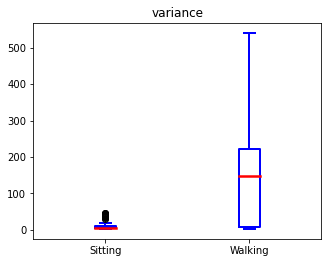

rms


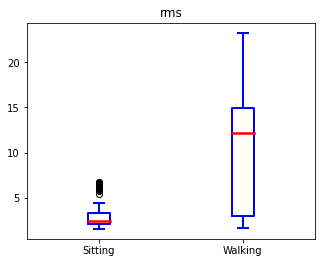

iemg


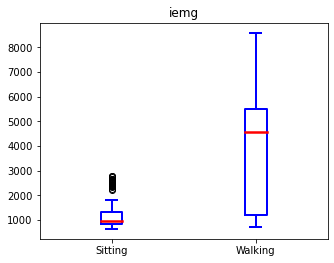

mav


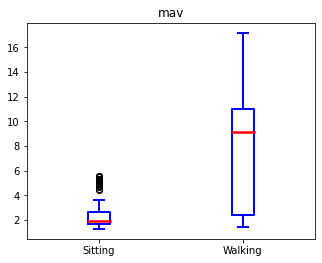

wl


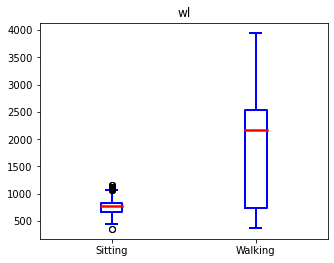

aac


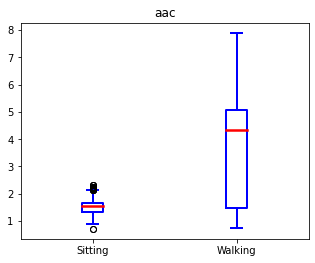

dasdv


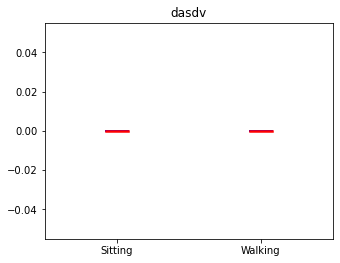

zc


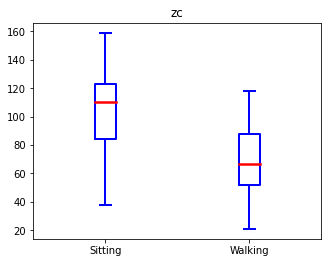

wamp


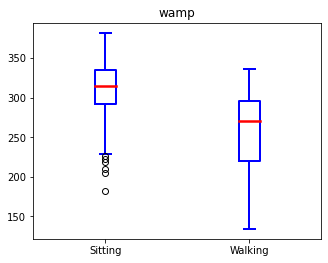

myop


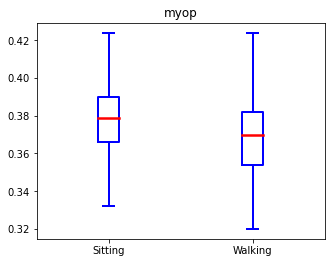

variance.1


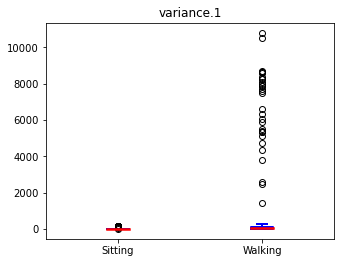

rms.1


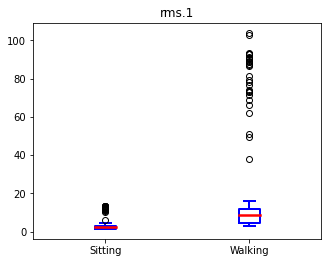

iemg.1


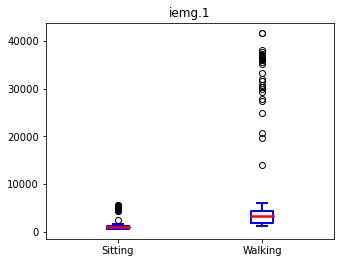

mav.1


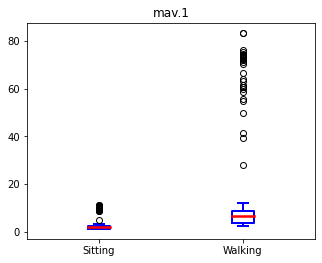

wl.1


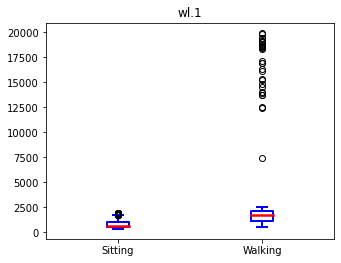

aac.1


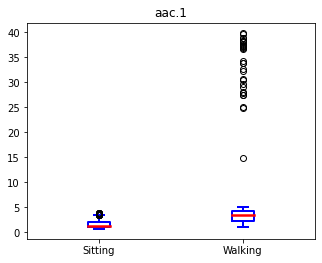

dasdv.1


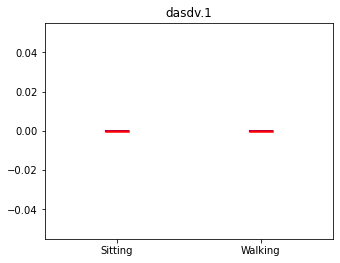

zc.1


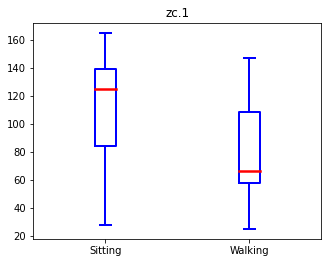

wamp.1


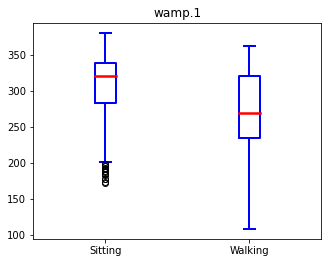

myop.1


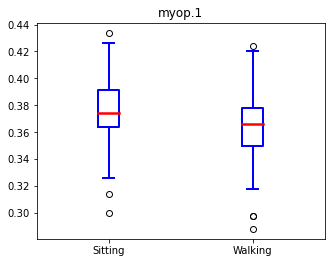

variance.2


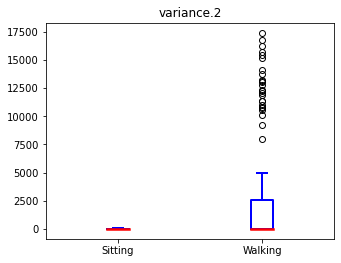

rms.2


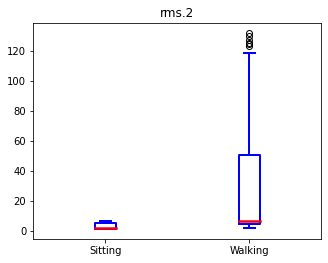

iemg.2


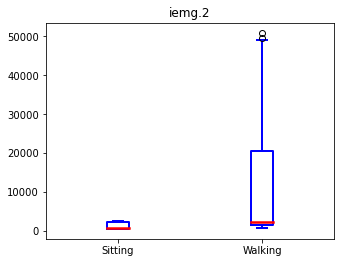

mav.2


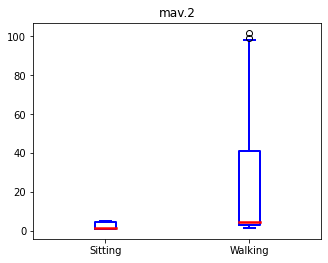

wl.2


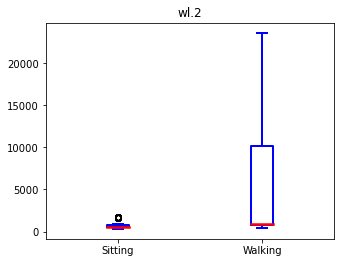

aac.2


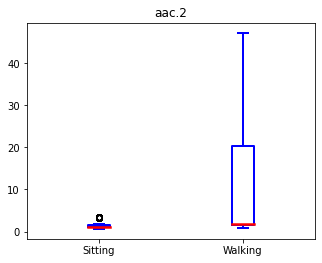

dasdv.2


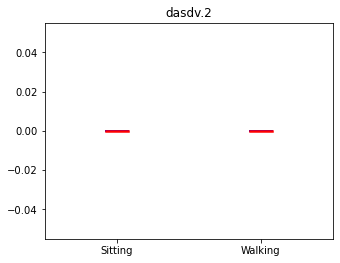

zc.2


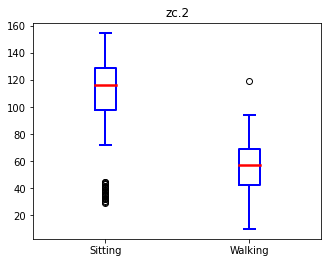

wamp.2


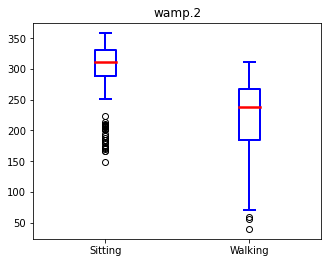

myop.2


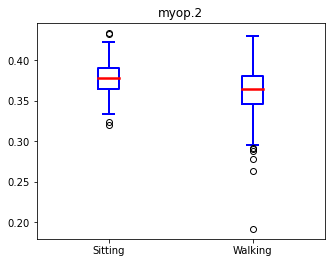

variance.3


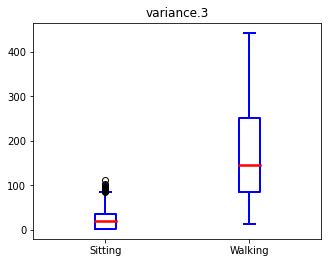

rms.3


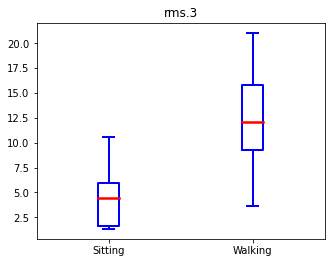

iemg.3


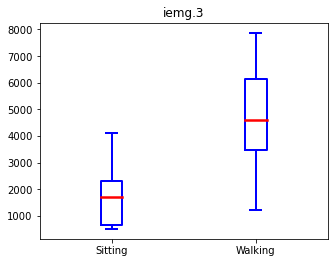

mav.3


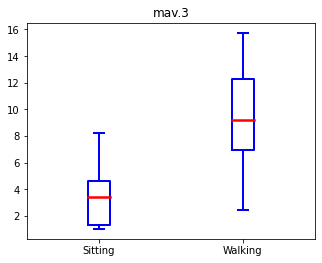

wl.3


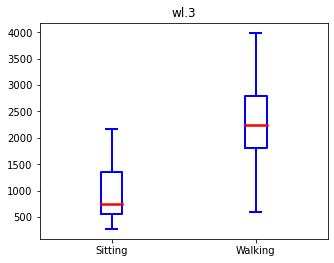

aac.3


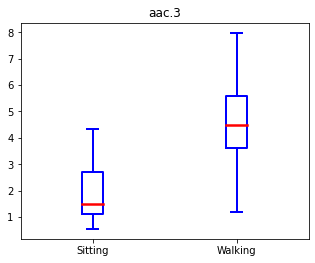

dasdv.3


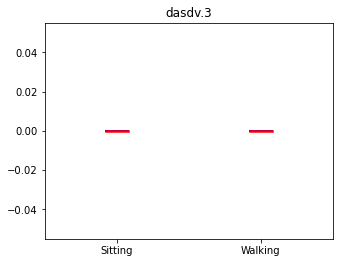

zc.3


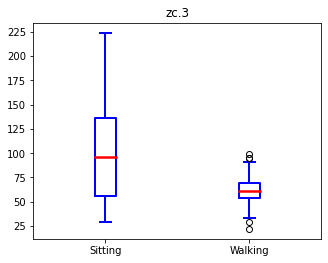

wamp.3


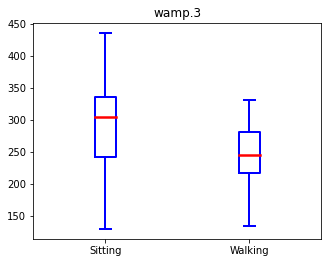

myop.3


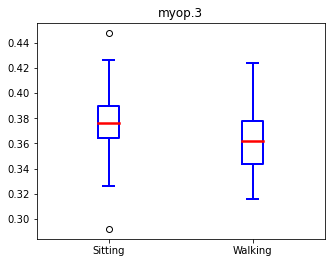

mean_0


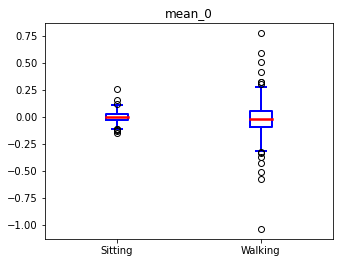

mean_1


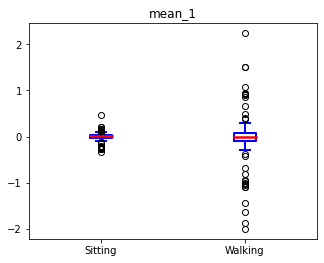

mean_2


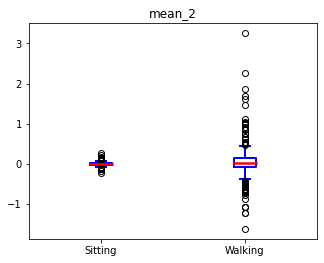

mean_3


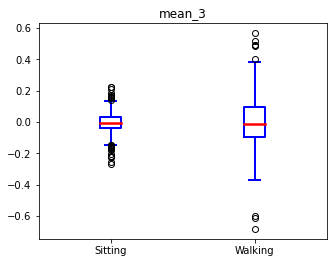

skew_0


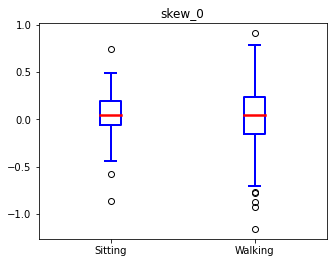

skew_1


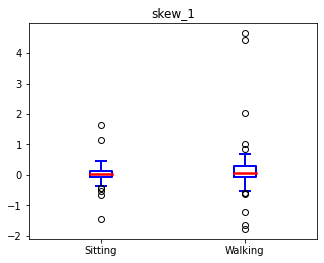

skew_2


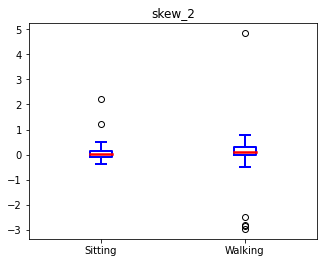

skew_3


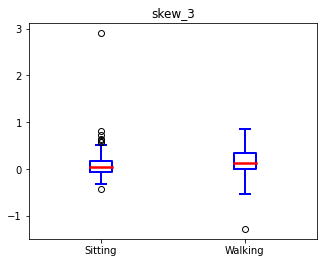

kurt_0


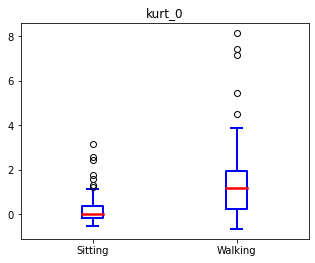

kurt_1


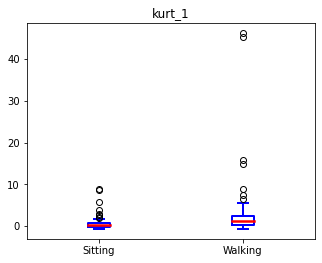

kurt_2


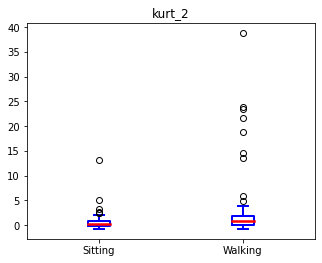

kurt_3


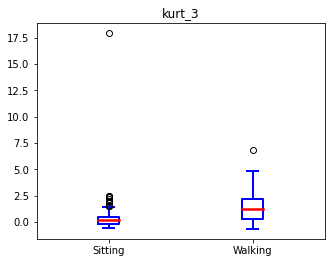

max_0


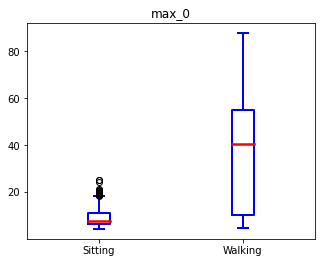

max_1


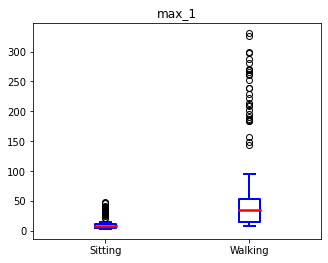

max_2


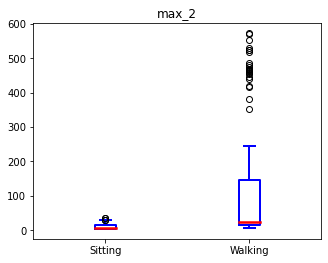

max_3


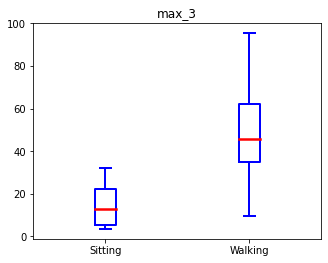

max_d_h2h1_0


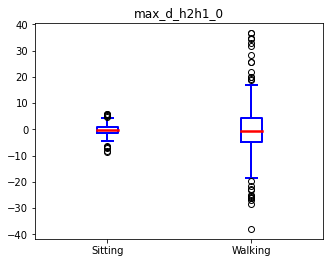

max_d_h2h1_1


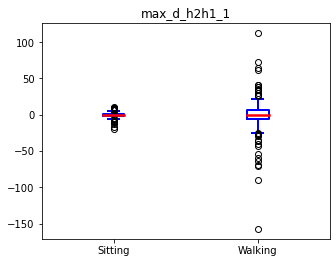

max_d_h2h1_2


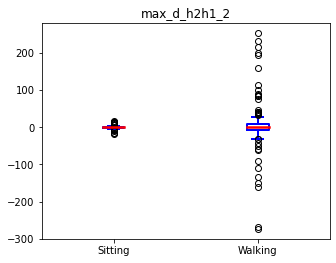

max_d_h2h1_3


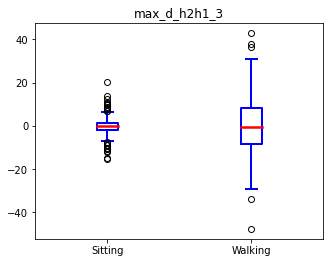

A3_mean


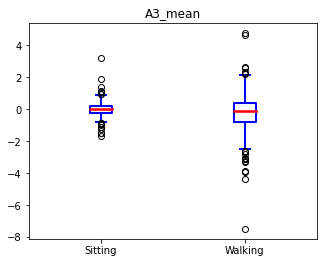

A3_std


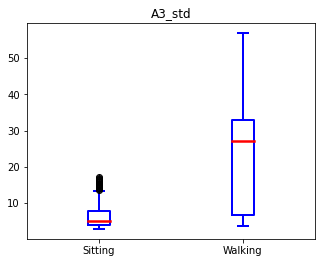

A3_energy


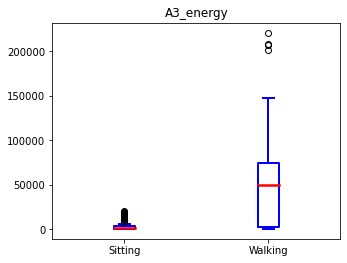

A3_entropy


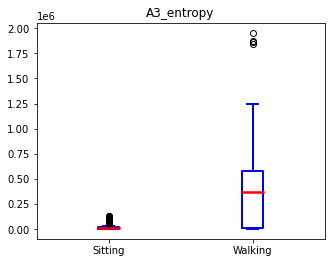

D3_mean


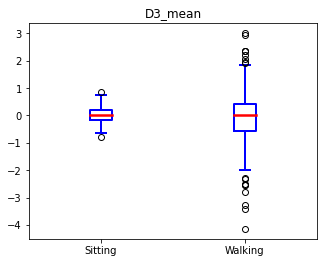

D3_std


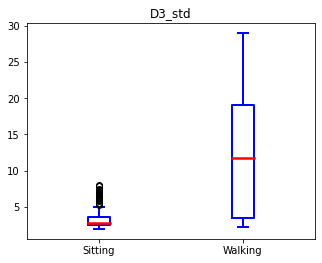

D3_energy


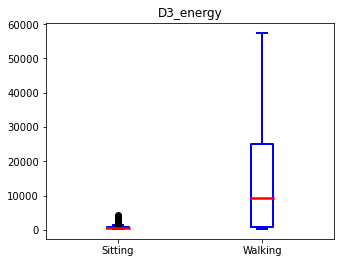

D3_entropy


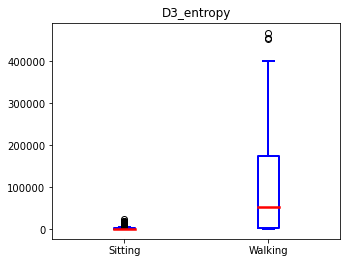

D2_mean


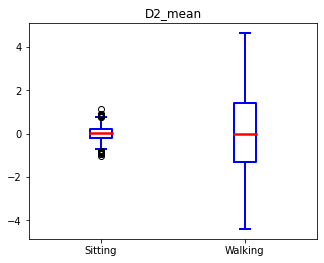

D2_std


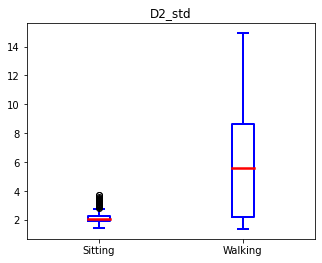

D2_energy


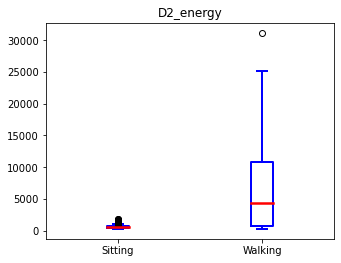

D2_entropy


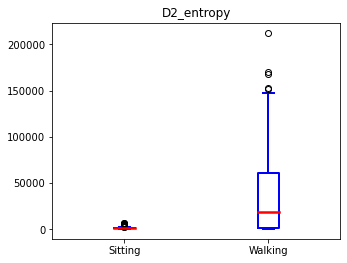

D1_mean


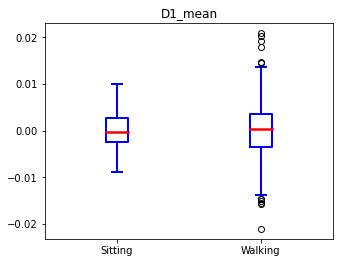

D1_std


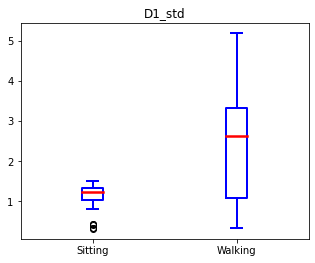

D1_energy


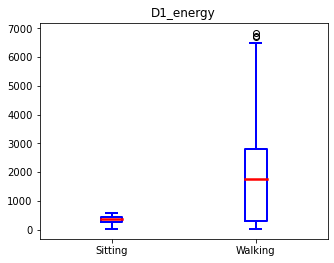

D1_entropy


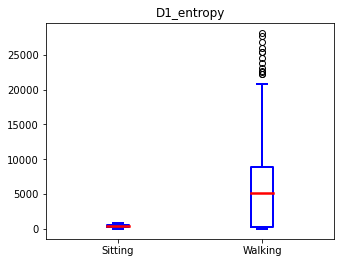

A3_mean.1


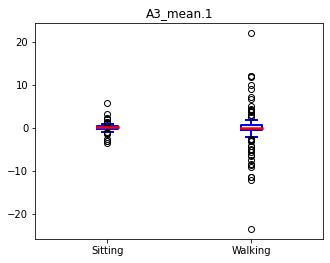

A3_std.1


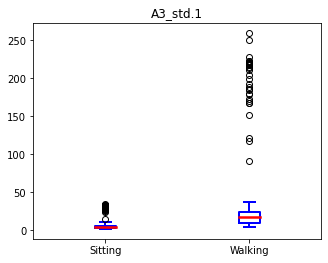

A3_energy.1


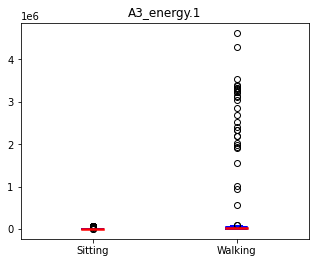

A3_entropy.1


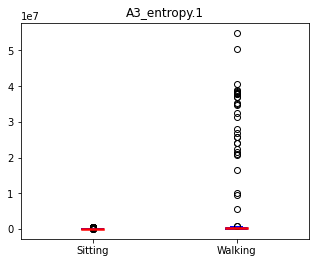

D3_mean.1


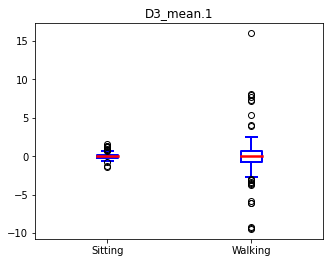

D3_std.1


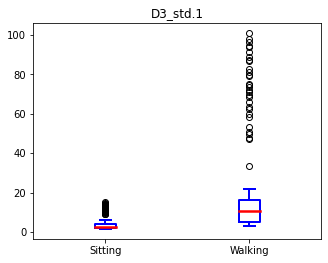

D3_energy.1


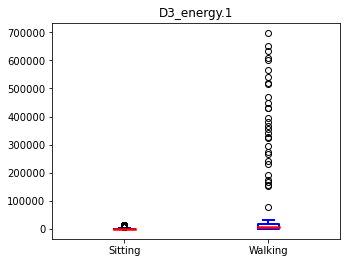

D3_entropy.1


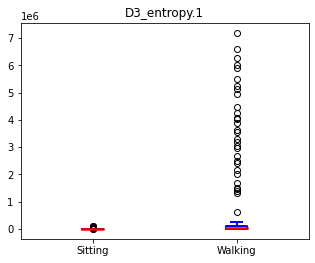

D2_mean.1


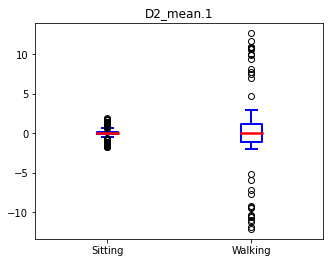

D2_std.1


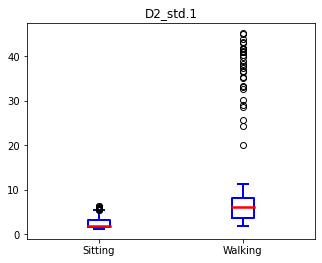

D2_energy.1


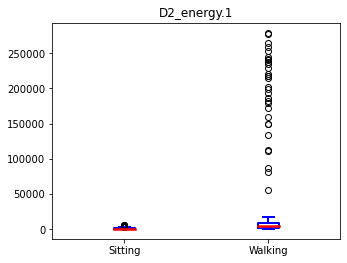

D2_entropy.1


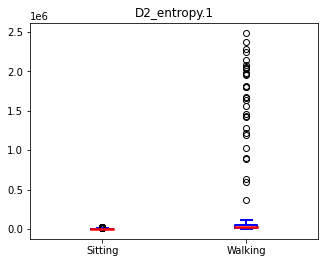

D1_mean.1


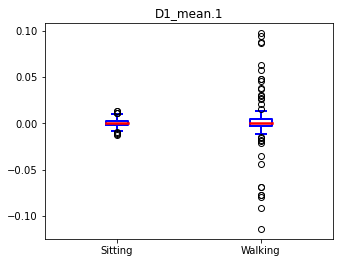

D1_std.1


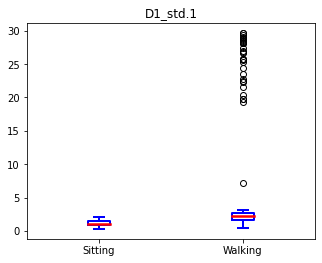

D1_energy.1


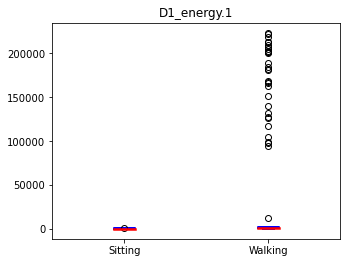

D1_entropy.1


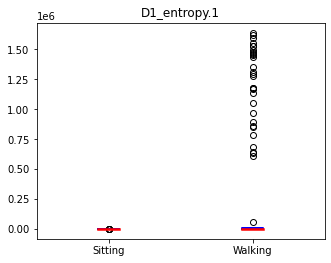

A3_mean.2


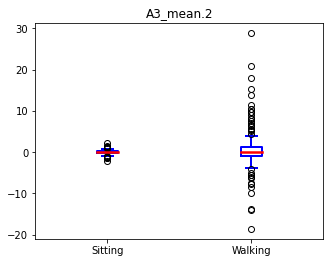

A3_std.2


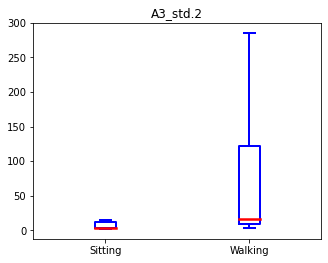

A3_energy.2


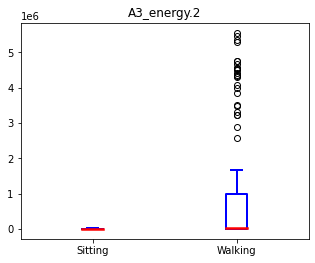

A3_entropy.2


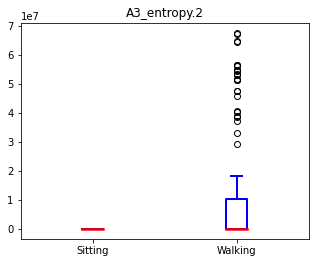

D3_mean.2


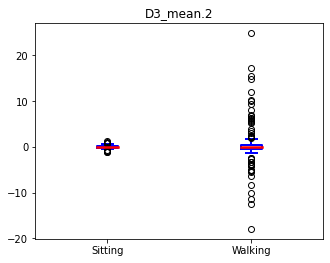

D3_std.2


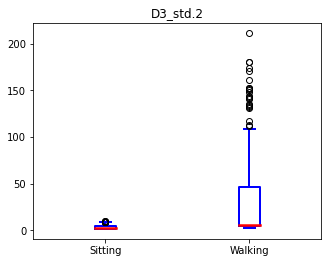

D3_energy.2


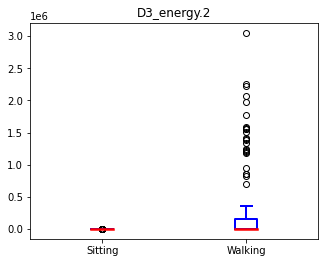

D3_entropy.2


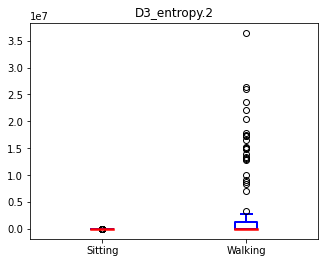

D2_mean.2


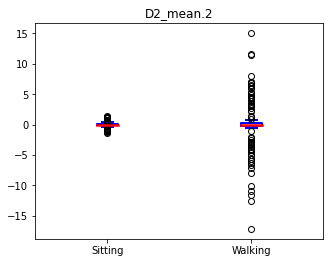

D2_std.2


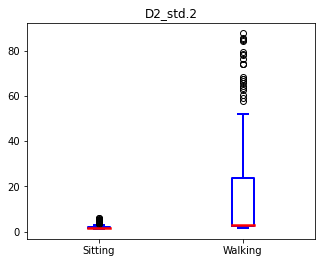

D2_energy.2


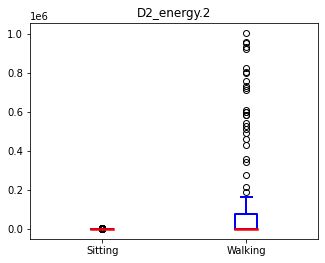

D2_entropy.2


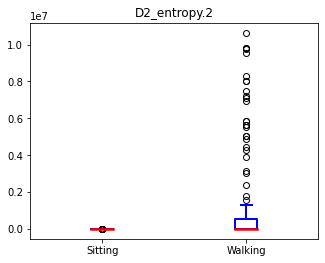

D1_mean.2


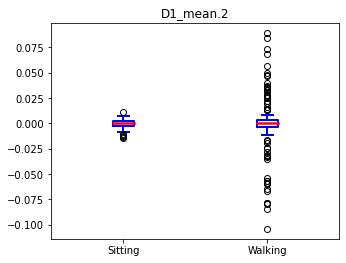

D1_std.2


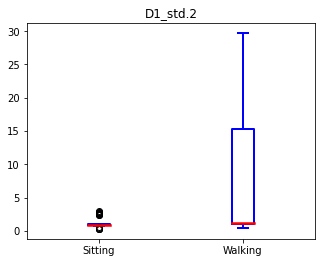

D1_energy.2


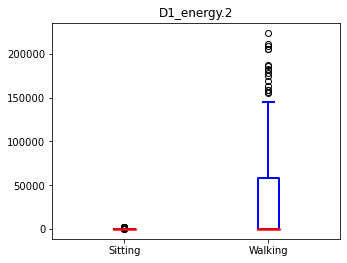

D1_entropy.2


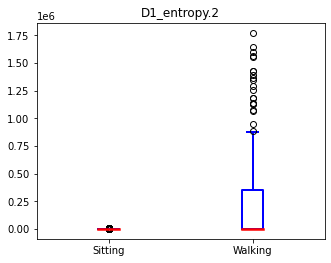

A3_mean.3


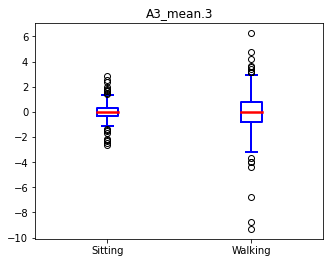

A3_std.3


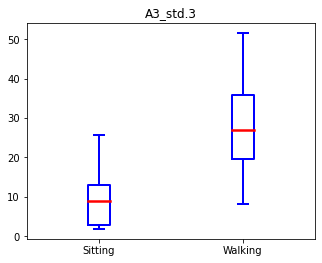

A3_energy.3


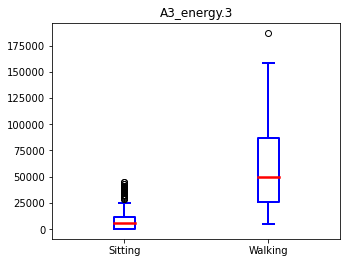

A3_entropy.3


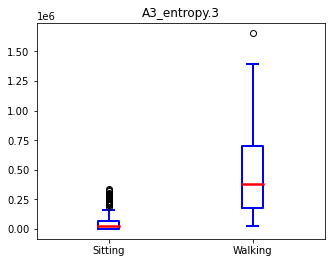

D3_mean.3


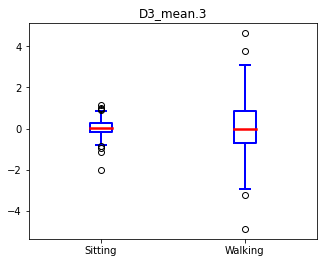

D3_std.3


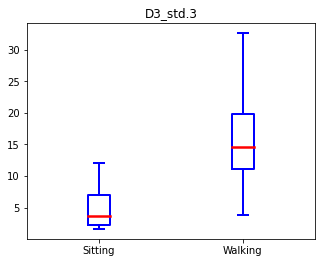

D3_energy.3


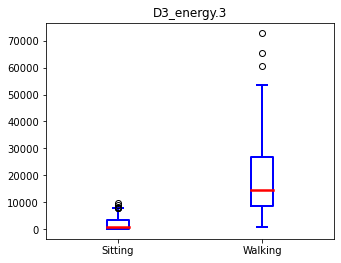

D3_entropy.3


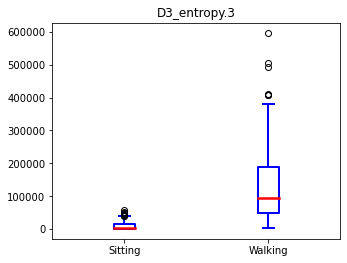

D2_mean.3


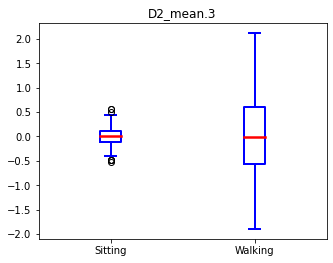

D2_std.3


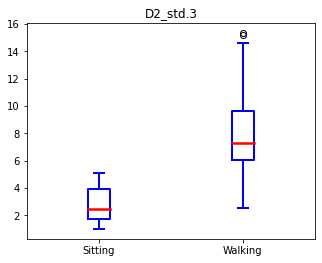

D2_energy.3


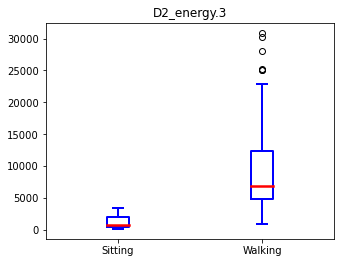

D2_entropy.3


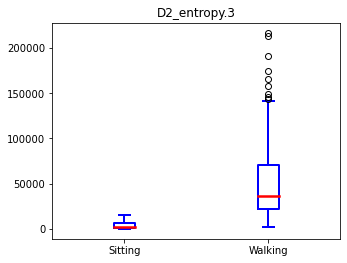

D1_mean.3


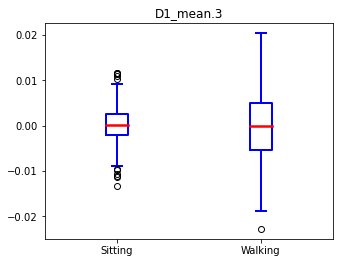

D1_std.3


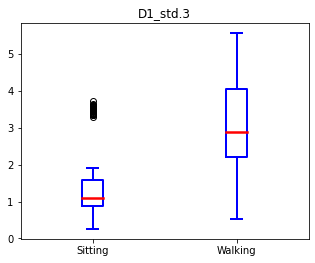

D1_energy.3


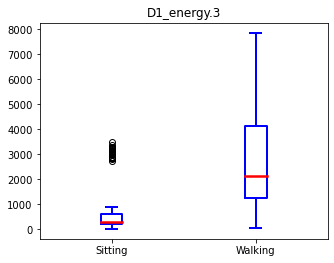

D1_entropy.3


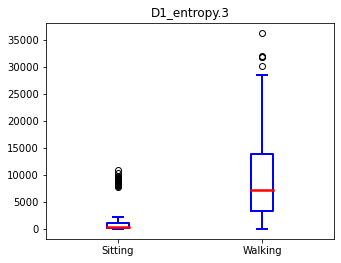

FR_0


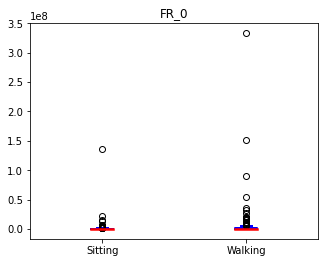

FR_1


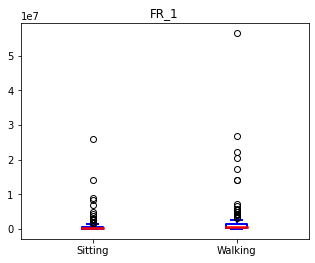

FR_2


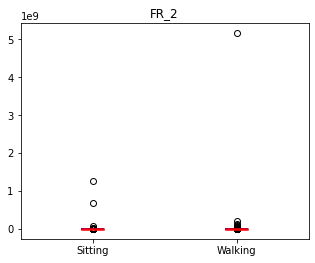

FR_3


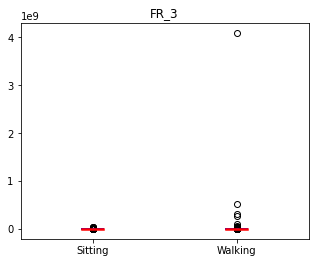

MNP_0


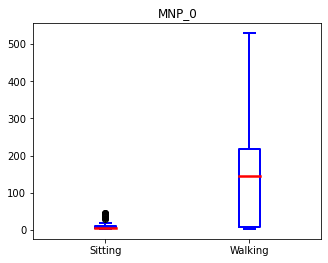

MNP_1


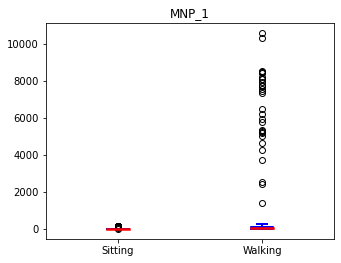

MNP_2


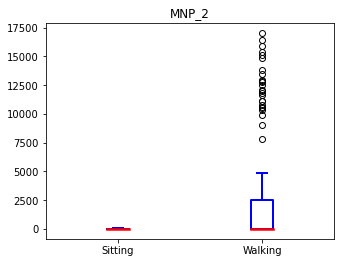

MNP_3


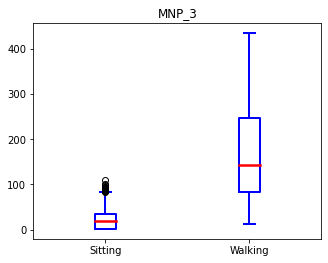

TOT_0


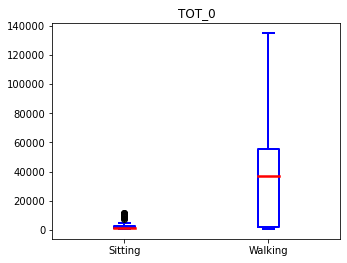

TOT_1


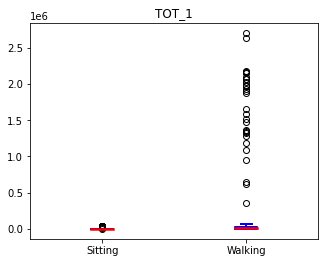

TOT_2


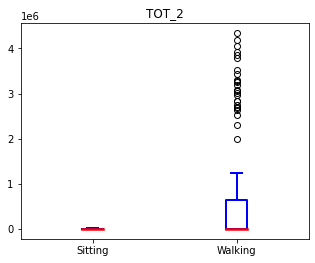

TOT_3


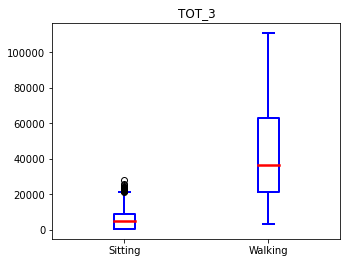

MNF_0


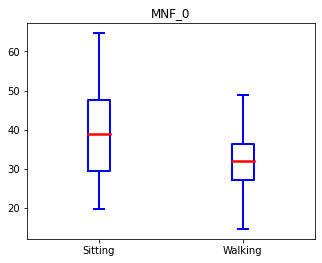

MNF_1


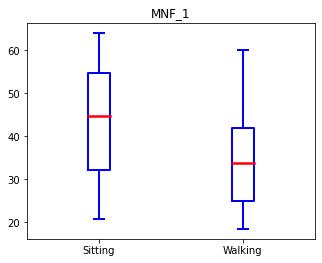

MNF_2


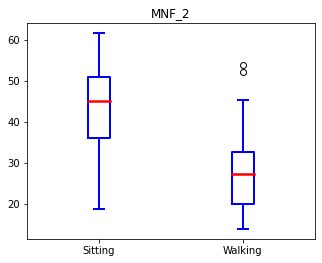

MNF_3


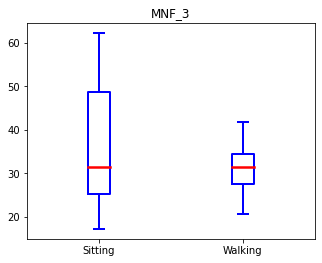

Label


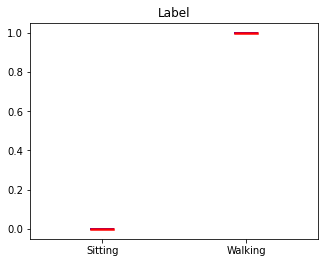

In [29]:

# Python program to illustrate
# boxplot 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

result = pd.read_csv(output_file_Train)
# Plotting boxplots
for column in result.columns:
    boxplot1(result, column)

In [30]:

import numpy as np
import pandas as pd
import os
import csv
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

In [31]:

Train_set = pd.read_csv(output_file_Train)
Test_set  = pd.read_csv(output_file_Test)


In [32]:
x=[]
xt=[]
y=[]
yt=[]



In [33]:
x = Train_set.iloc[:,0:-1-1].values
xt =  Test_set.iloc[:,0:-1-1].values

y = Train_set.iloc[:,-1].values
yt= Test_set.iloc[:,-1].values


In [34]:
x


array([[   4.133258  ,    2.03304428,  789.62923117, ...,   60.7827881 ,
          56.69421369,   36.34673794],
       [   4.61569313,    2.14841644,  865.69721642, ...,   58.0658161 ,
          53.3497189 ,   35.17723457],
       [   4.36306935,    2.08971499,  845.55246613, ...,   58.97318344,
          52.83431242,   38.60004427],
       ...,
       [  10.01514878,    3.16592448, 1236.89323753, ...,   35.15803825,
          25.59973207,   14.53856912],
       [   9.46558581,    3.07662102, 1205.49585942, ...,   33.98048826,
          20.4744471 ,   15.60043199],
       [   5.27566174,    2.29709026,  900.56729725, ...,   30.32599548,
          23.25701493,   24.56929523]])

In [35]:
x_train = x
y_train = y
x_test = xt
y_test = yt

Text(0, 0.5, 'AW1')

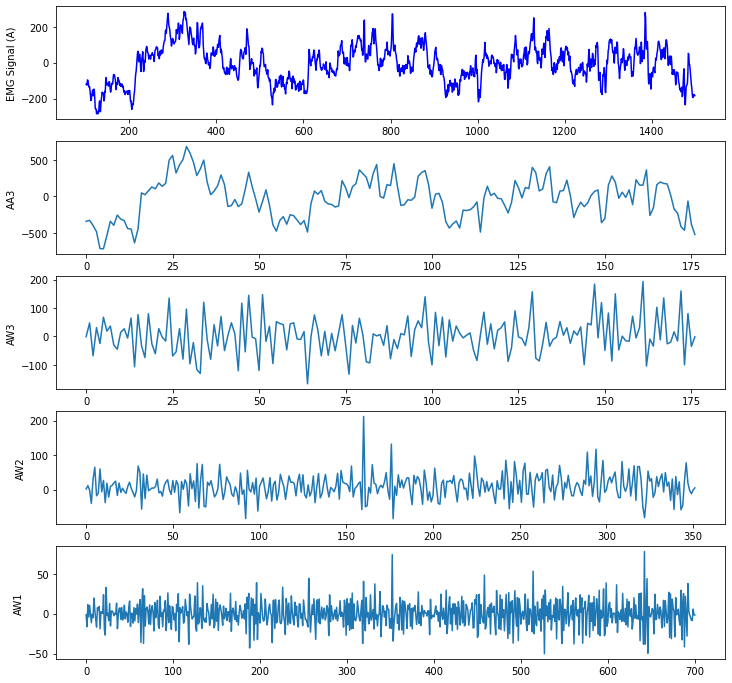

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import math

data=[]
data =  pd.read_csv('D:/PROJECTS/HPID_21/Train/Subtrain/1-walking-1.csv')
data_A = data.iloc[101:1500,3]
A_coeffs = pywt.wavedec(data_A, 'db2', level=3)
AA3, AW3, AW2, AW1 = A_coeffs

fig, axs = plt.subplots(5, figsize=(12,12))
axs[0].plot(data_A,'b')
axs[0].set_ylabel('EMG Signal (A)')
axs[1].plot(AA3)
axs[1].set_ylabel('AA3')
axs[2].plot(AW3)
axs[2].set_ylabel('AW3')
axs[3].plot(AW2)
axs[3].set_ylabel('AW2')
axs[4].plot(AW1)
axs[4].set_ylabel('AW1')

In [40]:
def notch_filter(x, samplerate, plot=False):
 
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt

In [41]:
def plot_freq_band (data_in):
    fs = 512                                # Sampling rate (512 Hz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data_in))
    
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data_in), 1.0/fs)
    #print(fft_freq)
    # Define EEG bands
    eeg_bands = {' 0 - 10Hz': (0, 10),
                 '11 - 20Hz': (11, 20),
                 '21 - 30Hz': (21, 30),
                 '31 - 40Hz': (31, 40),
                 '41 - 50Hz': (41, 50)}
                # '45 to 100 Hz':(45,100),
                 #'101 to 200 Hz':(101,200)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EMG band")
    ax.set_ylabel("Mean band Amplitude")

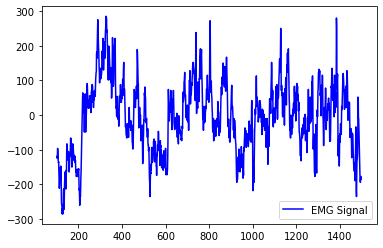

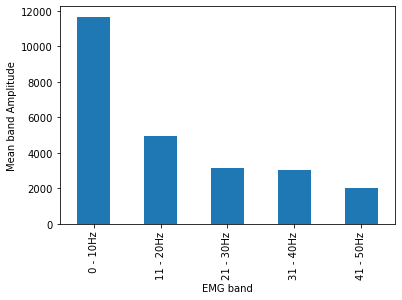

In [42]:
import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

#data_A = data.iloc[3000:5799,2]
plt.clf()
plt.plot(data_A,'b')
plt.legend(['EMG Signal'], loc = 'best')
plot_freq_band (data_A)
#plt.clf()


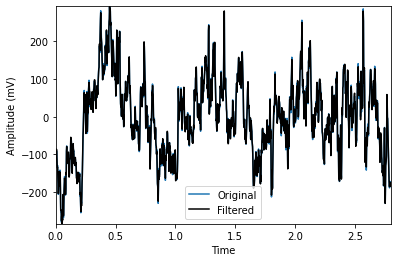

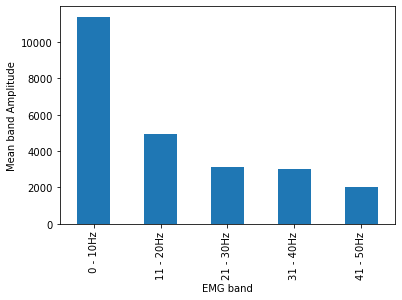

In [43]:
notch_out = notch_filter(data_A, samplerate=500, plot=True)
#plt.clf()
plot_freq_band (notch_out)
#plt.clf()

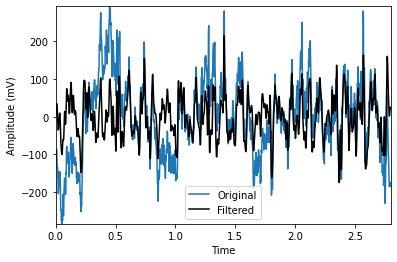

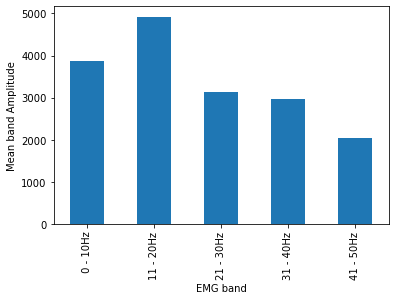

In [44]:
bp_out =  bp_filter(notch_out, low_f=5, high_f=80, samplerate=500, plot=True)
#plt.clf()
plot_freq_band (bp_out)

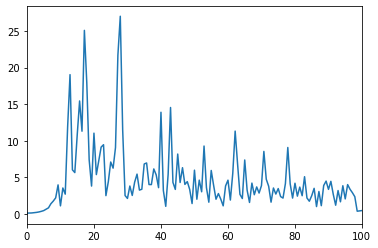

In [45]:
#Power spectral density
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
x= bp_out
dt = 0.001
#X = fft(x)
X=fft(x)/len(x)
freq = fftfreq(x.size, d=dt)

# Only keep positive frequencies.
keep = freq>=0
#X = X[keep]
X=X[keep]*2
freq = freq[keep]

ax1 = plt.subplot(111)
ax1.plot(freq, np.absolute(X))#/3000.)
ax1.set_xlim(0,100)

plt.show()

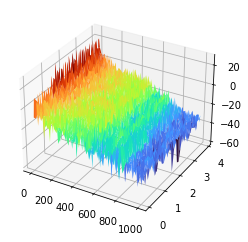

In [46]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map

mysignal =data.iloc[:,1] # CHANGE THE SIGNAL AND SEE PLOT

# basic config
sample_rate = 2000 #11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate thetimepoint
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate


# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(1,1,1,projection="3d"); 
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.turbo)
plt.show()


(1899,)


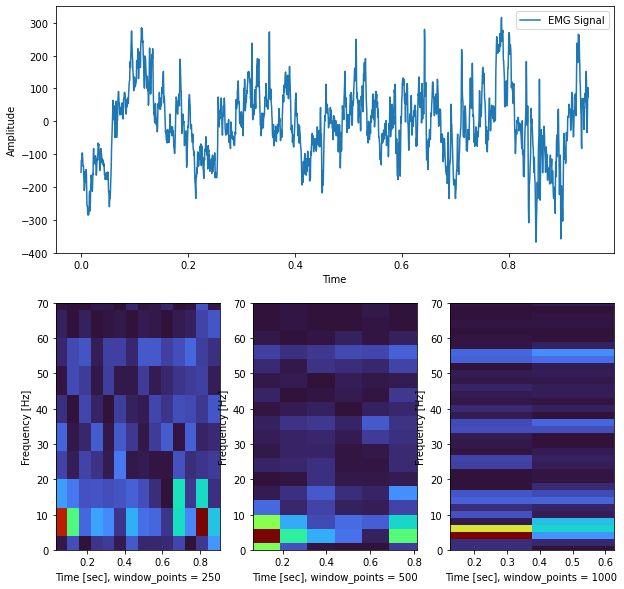

In [47]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#Windowing of signal for analysis and discussion of no of datapoints 
# We clim 500 to be the ideal number of data points 
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=250
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=1000
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
#50% OVERLAP FOR ALL 3 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 250')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 500')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 1000')


plt.show()

(1899,)


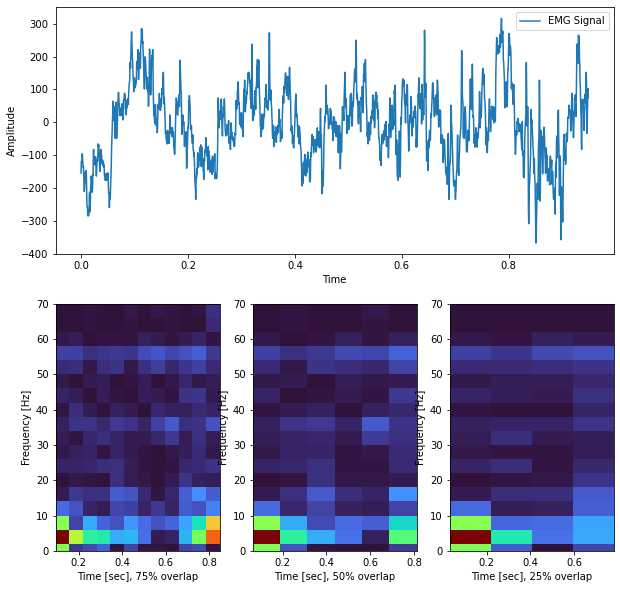

In [48]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#  overlapping of signal analysis and discussion of lenght of overlapping window
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=500
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//1.334,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//4,window=signal.get_window('hann',nperseg))
#ALL 3 have  500 Datapoints 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 75% overlap')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 50% overlap')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 25% overlap')


plt.show()

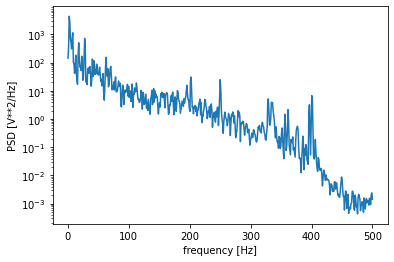

In [49]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# default Hann window an overlap of 50% 
#Compute and plot the power spectral density.
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 1000
x=data.iloc[100:2999,3]
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

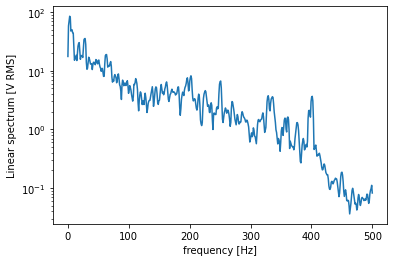

In [50]:
#compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

### Classification

In [65]:
#Decision Tree Classifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#from sklearn.metrics import accuracy_score
#Assign model with Decision Tree classifier
acc=[]
depth=[]
for mdepth in range(2, 20, 1):
    
    
    model1 = DecisionTreeClassifier(criterion = "gini",  #gini entropy
            random_state = 17000,max_depth=mdepth, min_samples_leaf=5)

    model1.fit(x_train, y_train)
    
    y_pred1 = model1.predict(x_test)
    acc.append(accuracy_score(y_test, y_pred1))
    depth.append(mdepth)
max_acc_index = acc.index(max(acc))  
print ('Optimum Depth is = ', depth[max_acc_index])
acc_max =   acc[max_acc_index]
print('Training ACC=', acc_max*100,'%')
optimum_depth = depth[max_acc_index]

#Using optimum depth value to train the model 
optimum_model = DecisionTreeClassifier(max_depth = optimum_depth) 
optimum_model.fit(x_train, y_train)

#Test the model 
y_pred = optimum_model.predict(x_test)




orig_class = y_test
pred_class = y_pred

print('ACC Test = ',accuracy_score(orig_class, pred_class))
print('RECALL = ', recall_score(orig_class, pred_class))
print('PRECISION = ', precision_score(orig_class, pred_class))
print('F1 SCORE = ', f1_score(orig_class, pred_class))

y_pred=[]

Optimum Depth is =  3
Training ACC= 90.32258064516128 %
ACC Test =  0.7419354838709677
RECALL =  0.9838709677419355
PRECISION =  0.6630434782608695
F1 SCORE =  0.7922077922077921


In [73]:
from sklearn import svm
model_svm_r = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')
model_svm_r.fit(x_train, y_train)
#joblib.dump(model_svm_r,"model_svm_r")
y_pred7 = model_svm_r.predict(x_test)
print("SVM RBF kernel")
print("Train Accuracy:",model_svm_r.score(x_train, y_train))
print("Test Accuracy:",model_svm_r.score(x_test, y_test))
print("Precision Score: ",metrics.precision_score(y_test, y_pred7, pos_label=1))
print("Recall Score: ",metrics.recall_score(y_test, y_pred7))
print("F1 Score: ",metrics.f1_score(y_test, y_pred7))


SVM RBF kernel
Train Accuracy: 1.0
Test Accuracy: 0.5
Precision Score:  0.5
Recall Score:  1.0
F1 Score:  0.6666666666666666


'''
#this code is probably causing problem of accuracy
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.NaN, strategy ='mean')
imputer = imputer.fit(x)
#x = imputer.transform(x)

imputer_test = imputer.fit(xt)
#xt = imputer_test.transform(xt)
'''

In [58]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(x_train, y_train)
#joblib.dump(model_knn,"model_knn")
y_pred3 = model_knn.predict(x_test)
print("KNN")
print("Train Accuracy:",model_knn.score(x_train, y_train))
print("Test Accuracy:",model_knn.score(x_test, y_test))
print("Precision Score: ",metrics.precision_score(y_test, y_pred3, pos_label='positive', average='weighted'))
print("Recall Score: ",metrics.recall_score(y_test, y_pred3, pos_label='positive', average='weighted'))
print("F1 Score: ",metrics.f1_score(y_test, y_pred3, pos_label='positive', average='weighted'))

KNN
Train Accuracy: 0.8413978494623656
Test Accuracy: 0.7741935483870968
Precision Score:  0.8444444444444444
Recall Score:  0.7741935483870968
F1 Score:  0.7620614035087719


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Train a single random forest classifier
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


orig_class = y_test
pred_class = y_pred
print('Training Accuracy =', accuracy_score(y_train, clf.predict(x_train)) * 100, '%')
print('ACC = ',accuracy_score(orig_class, pred_class))
print('RECALL = ', recall_score(orig_class, pred_class))
print('PRECISION = ', precision_score(orig_class, pred_class))
print('F1 SCORE = ', f1_score(orig_class, pred_class))
y_pred =[]

Training Accuracy = 98.11827956989248 %
ACC =  0.9919354838709677
RECALL =  0.9838709677419355
PRECISION =  1.0
F1 SCORE =  0.991869918699187
